# Simple Forward Simulation of Burgers Equation with phiflow

This chapter will give an introduction for how to run _forward_, i.e., regular simulations starting with a given initial state and approximating a later state numerically, and introduce the Φ<sub>Flow</sub> framework. Φ<sub>Flow</sub> provides a set of differentiable building blocks that directly interface with deep learning frameworks, and hence is a very good basis for the topics of this book. Before going for deeper and more complicated integrations, this notebook (and the next one), will show how regular simulations can be done with Φ<sub>Flow</sub>. Later on, we'll show that these simulations can be easily coupled with neural networks.

The main repository for Φ<sub>Flow</sub> (in the following "phiflow") is [https://github.com/tum-pbs/PhiFlow](https://github.com/tum-pbs/PhiFlow), and additional API documentation and examples can be found at [https://tum-pbs.github.io/PhiFlow/](https://tum-pbs.github.io/PhiFlow/).

For this jupyter notebook (and all following ones), you can find a _"[run in colab]"_ link at the end of the first paragraph (alternatively you can use the launch button at the top of the page). This will load the latest version from the PBDL github repo in a colab notebook that you can execute on the spot: 
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/overview-burgers-forw.ipynb)

## Model

As physical model we'll use Burgers equation.
This equation is a very simple, yet non-linear and non-trivial, model equation that can lead to interesting shock formations. Hence, it's a very good starting point for experiments, and it's 1D version (from equation {eq}`model-burgers1d`) is given by:

$$
    \frac{\partial u}{\partial{t}} + u \nabla u =
    \nu \nabla\cdot \nabla u
$$ 



## Importing and loading phiflow

Let's get some preliminaries out of the way: first we'll import the phiflow library, more specifically the `numpy` operators for fluid flow simulations: `phi.flow` (differentiable versions for a DL framework _X_ are loaded via `phi.X.flow` instead).

**Note:** Below, the first command with a "!" prefix will install the [phiflow python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment once you uncomment it. We've assumed that phiflow isn't installed, but if you have already done so, just comment out the first line (the same will hold for all following notebooks).

In [2]:
# !pip install --upgrade --quiet phiflow==3.1
from phi.flow import *

from phi import __version__
print("Using phiflow version: {}".format(phi.__version__))

Using phiflow version: 3.1.0


Next we can define and initialize the necessary constants (denoted by upper-case names):
our simulation domain will have `N=128` cells as discretization points for the 1D velocity $u$ in a periodic domain $\Omega$ for the interval $[-1,1]$. We'll use 32 time `STEPS` for a time interval of 1, giving us `DT=1/32`. Additionally, we'll use a viscosity `NU` of $\nu=0.01/\pi$.

We'll also define an initial state given by $-\text{sin}(\pi x)$ in the numpy array `INITIAL_NUMPY`, which we'll use to initialize the velocity $u$ in the simulation in the next cell. This initialization will produce a nice shock in the center of our domain. 

Phiflow is object-oriented and centered around field data in the form of grids (internally represented by a tensor object). I.e. you assemble your simulation by constructing a number of grids, and updating them over the course of time steps. 

Phiflow internally works with tensors that have named dimensions. This will be especially handy later on for 2D simulations with additional batch and channel dimensions, but for now we'll simply convert the 1D array into a phiflow tensor that has a single spatial dimension `'x'`.


In [3]:
N = 128
DX = 2./N
STEPS = 32
DT = 1./STEPS
NU = 0.01/(N*np.pi)

# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor



Next, we initialize a 1D `velocity` grid from the `INITIAL` numpy array that was converted into a tensor.
The extent of our domain $\Omega$ is specifiied via the `bounds` parameter $[-1,1]$, and the grid uses periodic boundary conditions (`extrapolation.PERIODIC`). These two properties are the main difference between phiflow's tensor and grid objects: the latter has boundary conditions and a physical extent.

Just to illustrate, we'll also print some info about the velocity object: it's a `phi.math` tensor with a size of 128. Note that the actual grid content is contained in the `values` of the grid. Below we're printing five entries by using the `numpy()` function to convert the content of the phiflow tensor into a numpy array. For tensors with more dimensions, we'd need to specify the additional dimenions here, e.g., `'y,x,vector'` for a 2D velocity field. (For tensors with a single dimensions we could leave it out.)

In [4]:
# velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init
vt = advect.semi_lagrangian(velocity, velocity, DT)

print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: "    + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.6748358  0.81720686 0.9313177  1.0781277  1.1678299 ]


## Running the simulation

Now we're ready to run the simulation itself. To compute the diffusion and advection components of our model equation we can simply call the existing `diffusion` and `semi_lagrangian` operators in phiflow: `diffuse.explicit(u,...)` computes an explicit diffusion step via central differences for the term $\nu \nabla\cdot \nabla u$ of our model. Next, `advect.semi_lagrangian(f,u)` is used for a stable first-order approximation of the transport of an arbitrary field `f` by a velocity `u`. In our model we have $\partial u / \partial{t} + u \nabla f$, hence we use the `semi_lagrangian` function to transport the velocity with itself in the implementation:

In [5]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)

print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))

New velocity content at t=1.0: [[-0.08533711]
 [-0.07209035]
 [-0.05884127]
 [-0.04558965]
 [-0.03233525]]


Here we're actually collecting all time steps in the list `velocities`. This is not necessary in general (and could consume lots of memory for long-running sims), but useful here to plot the evolution of the velocity states later on.

The print statements print a few of the velocity entries, and already show that something is happening in our simulation, but it's difficult to get an intuition for the behavior of the PDE just from these numbers. Hence, let's visualize the states over time to show what is happening.

## Visualization

We can visualize this 1D case easily in a graph: the following code shows the initial state in blue, and then times $10/32, 20/32, 1$ in green, cyan and purple. 

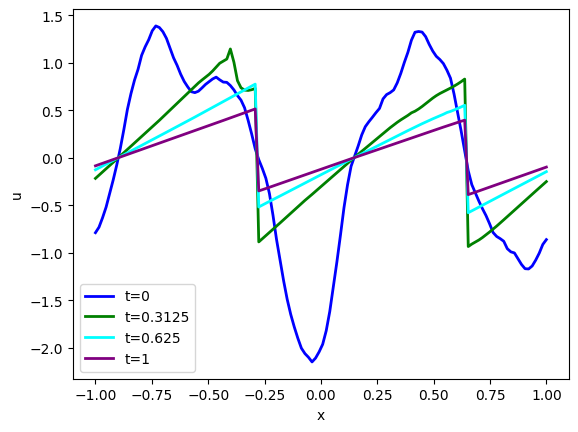

In [6]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays 

import pylab

fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()


This nicely shows the shock developing in the center of our domain, which forms from the collision of the two initial velocity "bumps", the positive one on left (moving right) and the negative one right of the center (moving left).

As these lines can overlap quite a bit we'll also use a different visualization in the following chapters that shows the evolution over the course of all time steps in a 2D image. Our 1D domain will be shown along the Y-axis, and each point along X will represent one time step.

The code below converts our collection of velocity states into a 2D array, repeating individual time steps 8 times to make the image a bit wider. This is purely optional, of course, but makes it easier to see what's happening in our Burgers simulation.

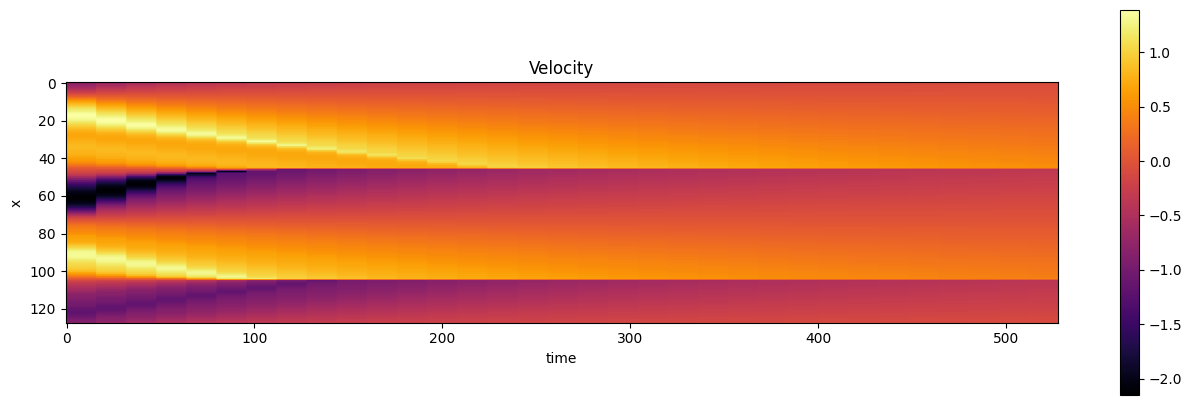

In [7]:
def show_state(a, title):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)

    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))

    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)
        
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 ) 

# save for comparison with reconstructions later on
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels_img, "Velocity")

This concludes a first simulation in phiflow. It's not overly complex, but because of that it's a good starting point for evaluating and comparing different physics-based deep learning approaches in the next chapter. But before that, we'll target a more complex simulation type in the next section.

## Next steps

Some things to try based on this simulation setup:

- Feel free to experiment - the setup above is very simple, you can change the simulation parameters, or the initialization. E.g., you can use a noise field via `Noise()` to get more chaotic results (cf. the comment in the `velocity` cell above).

- A bit more complicated: extend the simulation to 2D (or higher). This will require changes throughout, but all operators above support higher dimensions. Before trying this, you probably will want to check out the next example, which covers a 2D Navier-Stokes case.